<a href="https://colab.research.google.com/github/sesidhar-7/final_proj/blob/main/DenseNet201_Binary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 17.2 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.1
    Uninstalling typeguard-4.4.1:
      Successfully uninstalled typeguard-4.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.4.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install tensorflow==2.15.0
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 73.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.8 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.0
    Uninstalling wrapt-1.17.0:
      Successfully uninstalled wrapt-1.17.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: tensorboard
    Found existing installation

In [5]:
from tensorflow.keras.applications import DenseNet201, densenet
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import os
import numpy as np
import seaborn as sns
from tensorflow_addons.metrics import CohenKappa, F1Score
import kagglehub

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [6]:
!nvidia-smi

Mon Jan  6 12:21:21 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [23]:
import kagglehub
TARGET_SIZE = (128, 128)
BATCH_SIZE = 16
ROOT_DIRECTORY = kagglehub.dataset_download("sabari50312/fundus-pytorch")
LR = 0.0001
epochs = 20
fine_tuning_epochs = 20
total_epochs = epochs

In [24]:
#read images
def read_dataset(path):
    datagen = ImageDataGenerator(rescale = 1./255)

    train_dataset = datagen.flow_from_directory(os.path.join(path, "train"), target_size = TARGET_SIZE, batch_size = BATCH_SIZE, class_mode = 'binary')
    test_dataset = datagen.flow_from_directory(os.path.join(path, "test"), target_size = TARGET_SIZE, batch_size = BATCH_SIZE, class_mode = 'binary')
    val_dataset = datagen.flow_from_directory(os.path.join(path, "val"), target_size = TARGET_SIZE, batch_size = BATCH_SIZE, class_mode = 'binary')

    return train_dataset, test_dataset, val_dataset

In [25]:
train_dataset, test_dataset, val_dataset = read_dataset(ROOT_DIRECTORY)

Found 8621 images belonging to 2 classes.
Found 2874 images belonging to 2 classes.
Found 5747 images belonging to 2 classes.


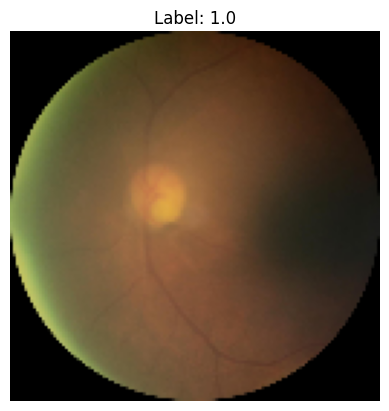

In [26]:

images, labels = next(train_dataset)

# Print the first image
plt.imshow(images[0])
plt.title("Label: " + str(labels[0]))
plt.axis('off')
plt.show()

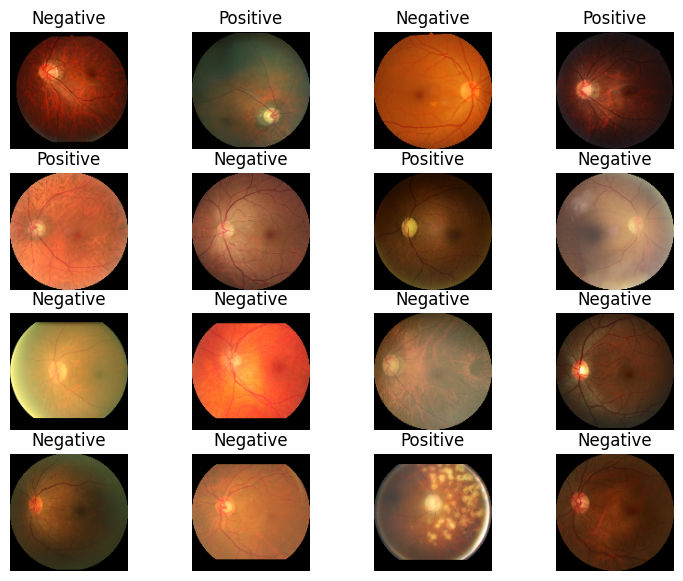

In [27]:
batch = next(train_dataset)
images, labels = batch

n_cols = 4
n_rows = 4

fig, ax = plt.subplots(n_rows, n_cols, figsize = (9, 7))
for i in range(n_rows):
    for j in range(n_cols):
        ax[i][j].imshow(images[i * n_cols + j])
        ax[i][j].set_title("Positive" if labels[i * n_cols + j] == 1.0 else "Negative")
        ax[i][j].axis("off")
plt.show()

In [ ]:
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    print("Building model...\n")
    base_model = DenseNet201(include_top = False, weights = 'imagenet', input_shape = TARGET_SIZE + (3,))

    base_model.trainable = True

    for layer in base_model.layers[:200]:
        layer.trainable = False

    model = tf.keras.Sequential()

    model.add(base_model)
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(128, activation = 'relu'))
    model.add(tf.keras.layers.Dense(32, activation = 'relu'))
    model.add(tf.keras.layers.Dense(8, activation = 'relu'))
    model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))


    model.summary()


    metrics = [
       tf.keras.metrics.TruePositives(name = 'tp'),
        tf.keras.metrics.TrueNegatives(name = 'tn'),
        tf.keras.metrics.FalsePositives(name = 'fp'),
        tf.keras.metrics.FalseNegatives(name = 'fn'),
        tf.keras.metrics.BinaryAccuracy(name = 'acc'),
        tf.keras.metrics.Recall(name = 'r'),
        tf.keras.metrics.Precision(name = 'p'),
        F1Score(num_classes = 2, threshold = 0.5, average='micro', name = 'F1')
    ]

    callbacks = [tf.keras.callbacks.ReduceLROnPlateau(factor = 0.3)]

    print("Compiling...\n")

    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate = LR),
        loss = tf.keras.losses.BinaryCrossentropy(),
        metrics = metrics,
    )
    print("Finished!\n")

    print("Fitting...\n")
    history_fit = model.fit(
        train_dataset,
        validation_data = val_dataset,
        batch_size = BATCH_SIZE,
        epochs = 100,
        verbose = 1,
        callbacks = callbacks,
        shuffle = True,
        initial_epoch = 0,
    )
    print("Finished!\n")



Building model...

74836368/74836368 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 4, 4, 1920)        18321984  
                                                                 
 global_average_pooling2d (  (None, 1920)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 128)               245888    
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dense_2 (Dense)             (None, 8)

In [ ]:
results = model.evaluate(test_dataset)

180/180 [==============================] - 50s 276ms/step - loss: 0.0027 - tp: 1120.0000 - tn: 1750.0000 - fp: 4.0000 - fn: 0.0000e+00 - acc: 0.9986 - r: 1.0000 - p: 0.9964 - F1: 0.9982


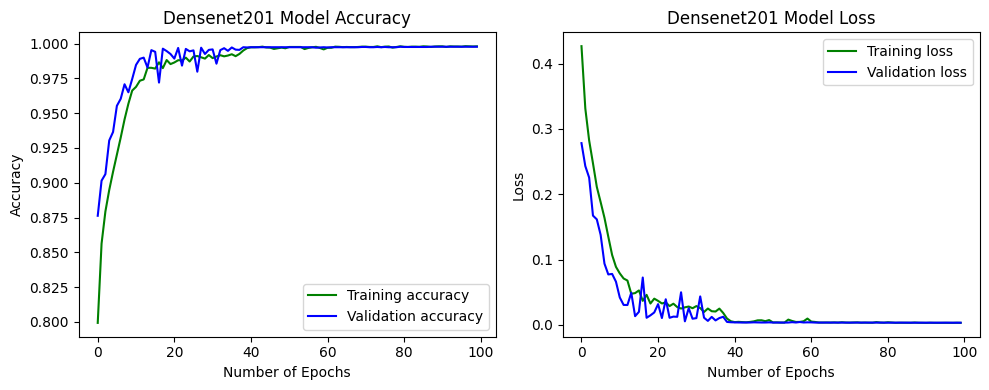

In [ ]:
loss_train = history_fit.history['loss']
loss_val = history_fit.history['val_loss']
accuracy_train = history_fit.history['acc']
accuracy_val = history_fit.history['val_acc']

plt.figure(figsize=(10, 4))
# Plotting loss curve
plt.subplot(1, 2, 1)
plt.title('Densenet201 Model Accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.plot(accuracy_train, 'g', label='Training accuracy')
plt.plot(accuracy_val, 'b', label='Validation accuracy')
plt.legend()

# Plotting accuracy curve
plt.subplot(1, 2, 2)

plt.title('Densenet201 Model Loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.plot(loss_train, 'g', label='Training loss')
plt.plot(loss_val, 'b', label='Validation loss')
plt.legend()

plt.tight_layout()  # To adjust the spacing between subplots

# Set the height and width of the plot


plt.show()

In [ ]:
confusion_matrix = [
    [results[2], results[4]],
    [results[3], results[1]],
]

Text(50.722222222222214, 0.5, 'True Label')

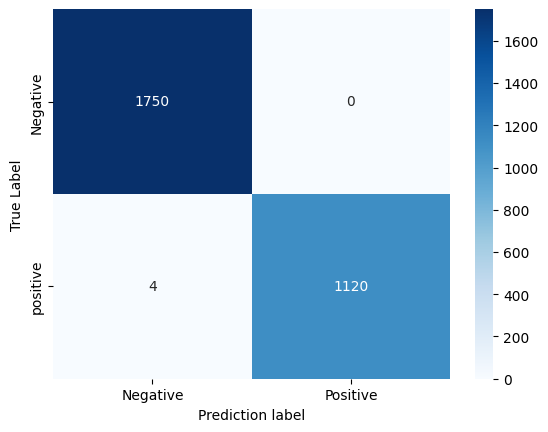

In [ ]:
sns.heatmap(confusion_matrix, annot = True, fmt = ".0f", cmap = 'Blues', xticklabels = ["Negative", "Positive"], yticklabels = ["Negative", "positive"])
plt.xlabel("Prediction label")
plt.ylabel("True Label")